In [3]:
from IPython.display import clear_output

In [16]:
!pip install ipykernel>=5.1.2
!pip install pydeck
clear_output()

Restart notebook.

# Set up Streamlit

In [10]:
!pip install streamlit
clear_output()

In [11]:
!pip install pyngrok==4.1.1
clear_output()

Download this notebook as *.py*

In [12]:
!ngrok authtoken 1zBEv43VFGiGrMwx8Vcikfr3XFN_2R1GK3nU4cf9KMETQjmqW
clear_output()

In [13]:
from pyngrok import ngrok

In [119]:
!streamlit run app.py&>/dev/null&

In [126]:
!pgrep streamlit

In [121]:
public_url = ngrok.connect(port='8501')
clear_output()

2021-10-07 19:01:40.346 INFO    pyngrok.process: t=2021-10-07T19:01:40+0000 lvl=info msg="started tunnel" obj=tunnels name=http-8501-c698356d-f513-4955-a819-78549a9b53fe addr=http://localhost:8501 url=https://57fd-35-197-66-211.ngrok.io

2021-10-07 19:01:40.348 INFO    pyngrok.process: t=2021-10-07T19:01:40+0000 lvl=info msg=end pg=/api/tunnels id=6f5f65b7d85ec60a status=201 dur=160.790695ms



In [122]:
public_url

'http://57fd-35-197-66-211.ngrok.io'

In [124]:
!kill 2611
clear_output()

In [125]:
ngrok.kill()
clear_output()

# Donwload Kaggle Dataset

In [4]:
! pip install kaggle
clear_output()

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d prathmeshgodse/food101-zip

100% 18.6G/18.6G [03:28<00:00, 63.8MB/s]
100% 18.6G/18.6G [03:28<00:00, 96.0MB/s]


In [9]:
!unzip food101-zip.zip
clear_output()

# Code

# Explore Dataset

In [59]:
import os
import torch
import torchvision
from torch.utils.data import random_split

In [60]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [61]:
data_dir = 'food-101'

transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

dataset = ImageFolder(data_dir+'/train', transform=transforms)

In [62]:
num_classes = 2
indices = list(range(0, num_classes*1000))
dataset_mini = torch.utils.data.Subset(dataset, indices)

In [63]:
img, label = dataset[1]
print(img.shape, label)

torch.Size([3, 128, 128]) 0


In [64]:
print(dataset.classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [65]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [66]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  apple_pie (0)


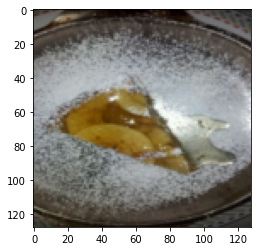

In [67]:
show_example(*dataset[0])

Label:  baby_back_ribs (1)


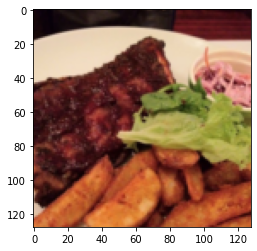

In [68]:
show_example(*dataset[1099])

# Training and Validation Datasets

In [69]:
random_seed = 42
torch.manual_seed(random_seed)

In [70]:
val_size = int(len(dataset_mini)/10)
train_size = len(dataset_mini) - val_size

train_ds, val_ds = random_split(dataset_mini, [train_size, val_size])
len(train_ds), len(val_ds)

(1800, 200)

In [71]:
from torch.utils.data.dataloader import DataLoader

batch_size=32

In [72]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=1, pin_memory=True)

In [73]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

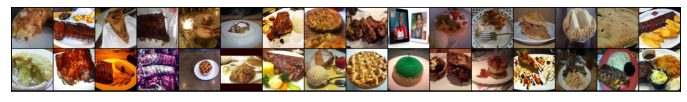

In [74]:
show_batch(train_dl)

# Define the Model

In [75]:
import torch.nn as nn
import torch.nn.functional as F

In [76]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [77]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16
            
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 512 x 32 x 32

            nn.Flatten(), 
            nn.Linear(256*16*16, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
    def forward(self, xb):
        return self.network(xb)

In [78]:
model = CnnModel()
# model

In [79]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


images.shape: torch.Size([32, 3, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


out.shape: torch.Size([32, 2])
out[0]: tensor([-0.4737,  0.1930], grad_fn=<SelectBackward>)


In [80]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [81]:
device = get_default_device()
device

device(type='cuda')

In [82]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
# to_device(model, device)

# Training the Model

In [83]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, optimizer):
    history = []
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
#         scheduler.step()
    return history

In [84]:
model = to_device(CnnModel(), device)

In [85]:
evaluate(model, val_dl)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


{'val_loss': 0.6944957971572876, 'val_acc': 0.46875}

In [86]:
num_epochs = 10
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

In [87]:
history = fit(num_epochs, lr, model, train_dl, val_dl, optimizer)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [0], train_loss: 0.4512, val_loss: 1.2641, val_acc: 0.6094


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [1], train_loss: 0.3673, val_loss: 2.6022, val_acc: 0.5312


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [2], train_loss: 0.3469, val_loss: 0.4585, val_acc: 0.8516


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [3], train_loss: 0.2980, val_loss: 0.6386, val_acc: 0.7422


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [4], train_loss: 0.3089, val_loss: 0.6558, val_acc: 0.7422


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [5], train_loss: 0.2703, val_loss: 2.1511, val_acc: 0.4961


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [6], train_loss: 0.2732, val_loss: 0.3802, val_acc: 0.8320


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [7], train_loss: 0.2403, val_loss: 0.4190, val_acc: 0.8516


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [8], train_loss: 0.2017, val_loss: 0.4384, val_acc: 0.8281


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch [9], train_loss: 0.2230, val_loss: 0.8019, val_acc: 0.6875


In [88]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

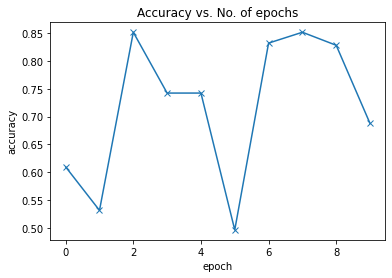

In [89]:
plot_accuracies(history)

In [90]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

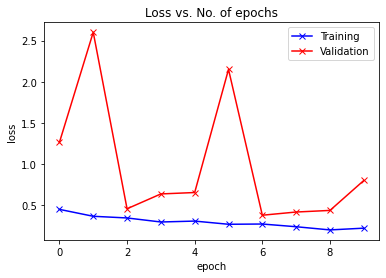

In [91]:
plot_losses(history)

# Save results

In [92]:
torch.save(model.state_dict(), 'model.pt')

In [94]:
import pickle

with open('data.pickle', 'wb') as f:
  pickle.dump(history, f)

# Testing

In [59]:
test_dataset = ImageFolder(data_dir+'/test', transform=transforms)

In [60]:
test_dataset_mini = torch.utils.data.Subset(test_dataset, indices)

In [62]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0)) 
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset_mini, batch_size*2), device)
result = evaluate(model, test_loader)
result